### Lets first import the important modules.

In [1]:
%matplotlib inline
import sklearn
import scipy.io as sio
import matplotlib.pylab as plt
import matplotlib as mp
import numpy as np
import scipy as sp
import scipy.ndimage
import scipy.signal


### And data

In [2]:
ft=sio.loadmat("firingTimes.mat")

print ft.keys()

allSpikes=ft['allSpikes']
totalTime=ft['totalTime']*1.0
neuronsWithInput=ft['neuronsWithInput']
neuronsWithInput_array=np.zeros(160)
neuronsWithInput_array[neuronsWithInput]=1

['totalTime', 'spikes', 'all_v_mat', 'allSpikes', 'firings2', '__header__', '__globals__', 'allFirings', 'firings', 'neuronsWithInput', 'spikes2', '__version__', 'v_mat', 'v_mat2']


### Lets make a basic raster plot of spikes using spike times from spike trains generated with the poisson distribution

In [3]:
# generating poisson data
num_neurons=10
max_time=100
spike_array=(np.random.random([num_neurons,max_time]) <0.1)
neurons,time=np.where(spike_array==1)

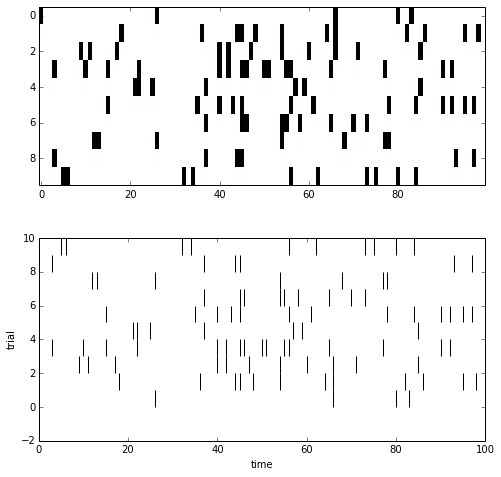

In [4]:
# plotting rasters in two ways
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.imshow(spike_array,aspect=4,interpolation='none',cmap='Greys')
plt.subplot(212)
plt.vlines(time,neurons,neurons+1)
plt.xlabel('time')
plt.ylabel('trial')
plt.show()

In the cell below, make the raster plots for the data in the array allSpikes (same format as spike_array above)

### Lets make a histogram of average spiking rate

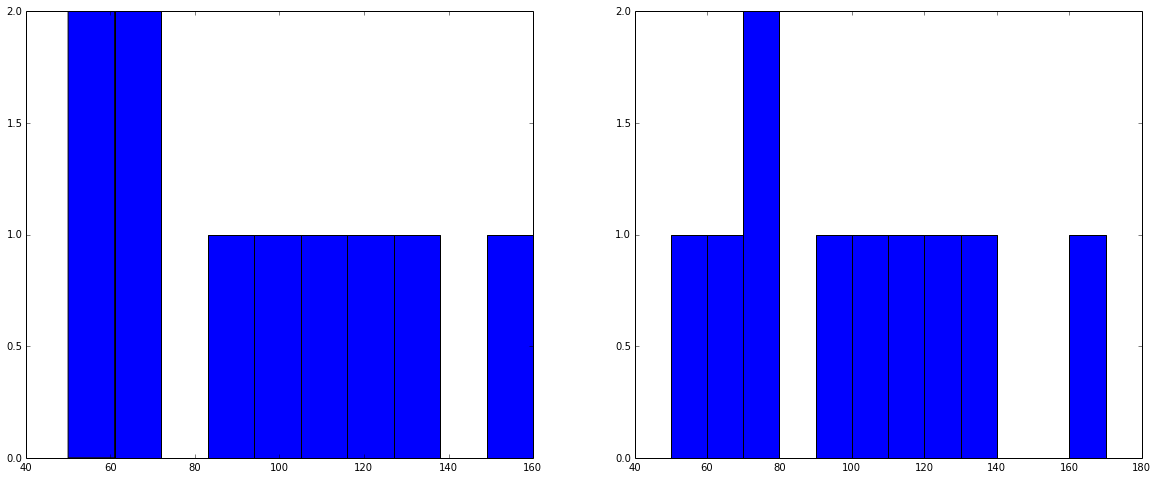

In [5]:
spikes_per_sec = np.mean(spike_array,1)*1000
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.hist(spikes_per_sec,bins=10)
plt.subplot(122)
plt.hist(spikes_per_sec,bins=range(0,200,10))
plt.show()

In the cell below. Make a histogram for the allSpikes data. Find a good binsize to get a nice looking plot.

### Let us see how the instantanoues firing rate of the neurons changes over time

To do this, we will combine every 5 data point into 1 so that we get an average

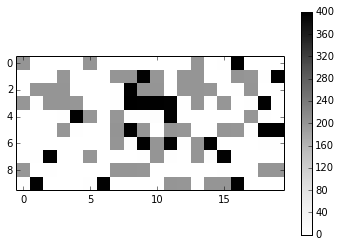

In [6]:
combine_points=5
mean_rate_over_time=np.zeros([spike_array.shape[0],spike_array.shape[1]/combine_points])
for i in range(spike_array.shape[1]/combine_points):
    mean_rate_over_time[:,i]=np.mean(spike_array[:,combine_points*i:combine_points*(i+1)],1)*1000
plt.imshow(mean_rate_over_time,interpolation='none',cmap='Greys')
plt.colorbar()
plt.show()


In the cell below, implement this for allSpike data and then see the effect of changing the number of points we combine

### A way to get smoother data is to use filters on the spike train.

Lets use the built in uniform filter to understand what is happening.

In [7]:
unif_filtered=np.zeros(spike_array.shape)
size_of_filter=10
for i in range(spike_array.shape[0]):
    unif_filtered[i,:]=sp.ndimage.filters.uniform_filter1d(spike_array[i,:]*1000,size_of_filter,mode='wrap')

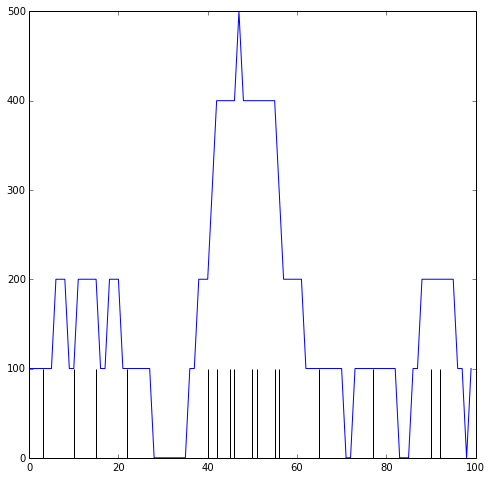

In [8]:
plt.figure(figsize=(8, 8))
i_th_neuron=3
plt.plot(unif_filtered[i_th_neuron,:])
plt.vlines(np.where(spike_array[i_th_neuron,:]==1)[0],0,100)


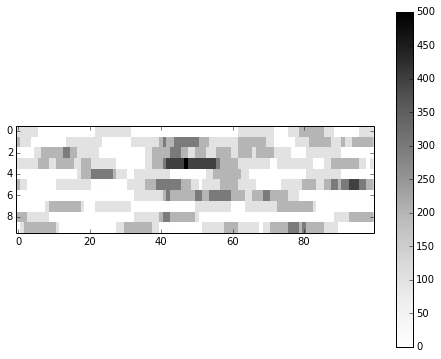

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(unif_filtered,aspect=3,cmap='Greys',interpolation="None")
plt.colorbar()
plt.show()

In the cell below, use the filter for the allSpikes. The instead of 

sp.ndimage.filters.uniform_filter1d 

use

sp.ndimage.filters.gaussian_filter1d . 

Experiment with what happens when you change filter size.

### Now we will try to use a custom filter instead of the standard ones

First lets make an array which has an exponential shape. This array will be used as the filter.

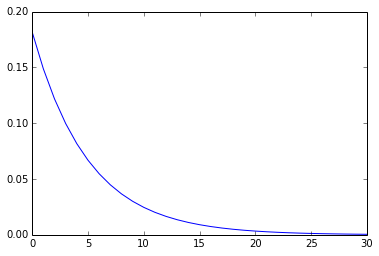

In [15]:
filter_size=30
tau=5.0
arr=np.linspace(0,filter_size,filter_size+1)
filter_exp=np.exp(-arr/tau)


filter_exp=filter_exp/sum(filter_exp) #normalize the filter so that its area is 1
plt.plot(filter_exp)
plt.show()

Now we can apply this using the function sp.ndimage.filters.convolve1d

In [16]:
exp_filtered=np.zeros(spike_array.shape)
for i in range(spike_array.shape[0]):
    exp_filtered[i,:]=sp.ndimage.filters.convolve1d(spike_array[i,:]*1000,filter_exp,mode='constant',origin=(-1*filter_size-1)/2)

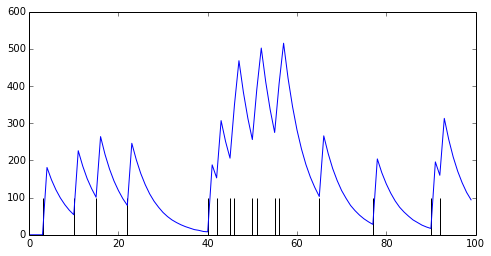

In [17]:
plt.figure(figsize=(8, 4))
i_th_neuron=3
plt.plot(exp_filtered[i_th_neuron,:])
plt.vlines(np.where(spike_array[i_th_neuron,:]==1)[0],0,100)
plt.show()

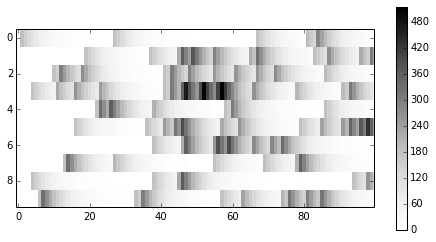

In [18]:
plt.figure(figsize=(8, 4))
plt.imshow(exp_filtered,aspect=5,cmap='Greys',interpolation="None")
plt.colorbar()
plt.show()

In the cell below, implement this for allSpikes data. Then try to change the size of the filter and the tau of the filter.



Now, in the cell below, try to use a tringular filter (like the shape of a pyramid)

## PSTH

Lets make peristimulus histogram. To do this, just find all the times at which neurons spike. The plot a histogram of those.



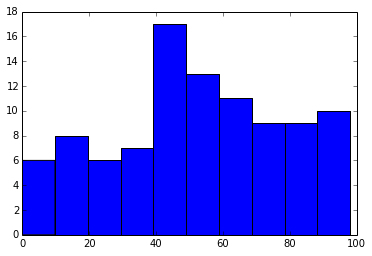

In [14]:
neurons,time=np.where(spike_array==1)
plt.hist(time,bins=10)
plt.show()

In the cell below, do the same for allSpikedata

# Machine learning

Now that we have done some basic analysis on spike train data, lets do some Machine learning.

### We will start with K-Means clustering of data

In [19]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_samples = 150
random_state = 170
X_test, y_test = make_blobs(n_samples=n_samples, random_state=random_state)

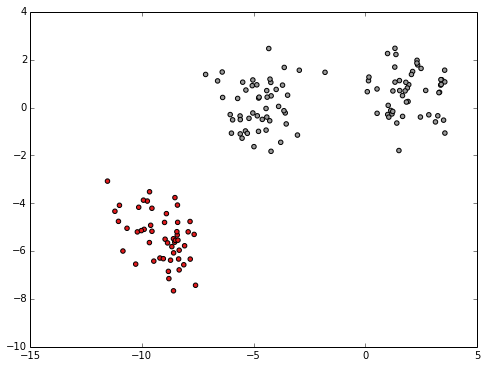

In [20]:
km=KMeans(n_clusters=2, random_state=random_state)
y_pred = km.fit_predict(X_test)
labels=km.labels_
cluster_centers=km.cluster_centers_
plt.figure(figsize=(8, 6))
# plt.subplot(221)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred,cmap='Set1')
plt.show()

In [21]:
D_average = km.inertia_
print D_average

1428.10889712


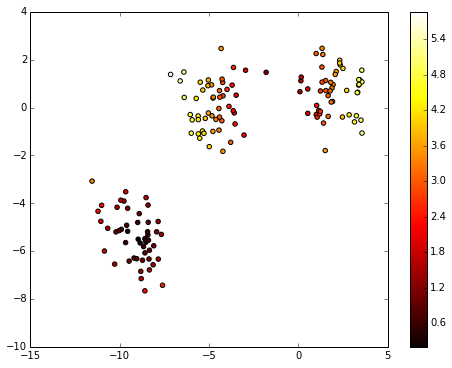

In [22]:
def calc_dist(labels,X,cluster_centers):
    Y=np.zeros(X.shape[0])
    for i,j in enumerate(labels):
        Y[i]=np.linalg.norm(X[i,:]-cluster_centers[j])
    return Y
dist = calc_dist(labels,X_test,cluster_centers)
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=dist,cmap='hot')
plt.colorbar()
plt.show()

## Lets apply k means on neural data

### lets load and visualize the data

In [23]:
ft1=sio.loadmat("forclustering.mat")
new_spiketrain=ft1['new_spiketrain']

(250, 10000)


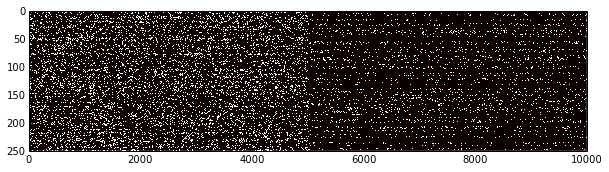

In [24]:
print new_spiketrain.shape
plt.figure(figsize=[10,10])
plt.imshow(new_spiketrain,aspect=10,cmap='hot',interpolation="None")
plt.show()

### We need to preprocess data before we can apply machine learning on it. Lets filter it appropriately.

In [25]:
filtered_new=np.zeros(new_spiketrain.shape)
size_of_filter=100  # set an appropriate filter size.
for i in range(new_spiketrain.shape[0]):
    filtered_new[i,:]=sp.ndimage.filters.gaussian_filter1d(new_spiketrain[i,:]*1000,size_of_filter,mode='constant')

### Generally maching learning can be done well on features extracted from raw data. 

We'll extract some features using Principal Component Analysis. (PCA)

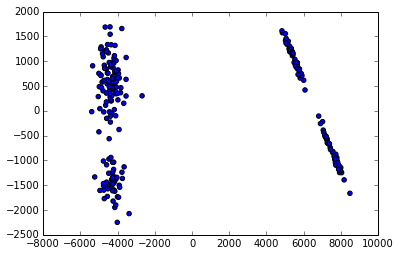

In [26]:
from sklearn.decomposition import PCA
reduced_data=PCA(n_components=2).fit_transform(filtered_new - np.mean(filtered_new))
plt.scatter(reduced_data[:,0],reduced_data[:,1],cmap='Set3')
plt.show()

### As it turns out, in this case, the principle components are essentially the mean firing rate and the variance.

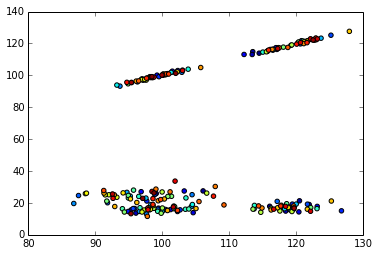

In [27]:
x1=np.mean(filtered_new,axis=1)
x2=np.std(filtered_new,axis=1)
X=np.array([x1,x2]).T
plt.scatter(X[:, 0], X[:, 1],c=range(X.shape[0]),cmap='jet')
plt.show()


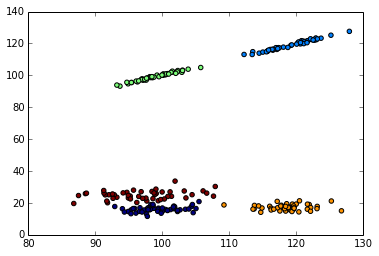

4736.57576425


In [28]:
km=KMeans(n_clusters=5, random_state=random_state) # play with cluster size
y_pred = km.fit_predict(X)
labels=km.labels_
cluster_centers=km.cluster_centers_
plt.scatter(X[:, 0], X[:, 1], c=y_pred,cmap='jet')
plt.show()
D_original = km.inertia_
print D_original


## Permutation test!

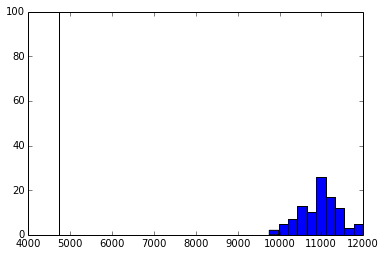

In [29]:
x1=np.mean(filtered_new,axis=1)
x2=np.std(filtered_new,axis=1)
n_repeat=100
D_permute=np.zeros(n_repeat)
D_non_permute=np.zeros(n_repeat)
for i in range(n_repeat):
    permutation= np.random.permutation(range(x1.shape[0]))
    X_permuted=np.array([x1[permutation],x2]).T
    X_non_permuted=np.array([x1,x2]).T
        
    km=KMeans(n_clusters=5, random_state=random_state)
    y_pred = km.fit_predict(X_permuted)
    D_permute[i]=km.inertia_
    
    km=KMeans(n_clusters=5, random_state=random_state)
    y_pred = km.fit_predict(X_non_permuted)
    D_non_permute[i]=km.inertia_
plt.hist(D_permute)
plt.hist(D_non_permute)
plt.show()

## Bonus question. Try to cluster the allSpike data using Kmeans

In the box below

# Supervised Learning : Generalized Linear Models (GLM)

Lets generate some silly data.

In [30]:
X_lin=np.random.random([10,100])
c=np.random.random(10)
Y_lin=c.dot(X_lin)+np.random.random(100)

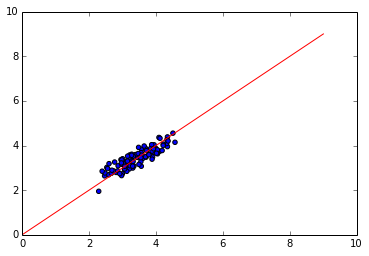

In [31]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(X_lin.T,Y_lin)
y2=clf.predict(X_lin.T)
plt.scatter(Y_lin,y2)
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot(np.arange(10),np.arange(10),"r")
plt.show()

## Now let us apply this on some neural data.

In [32]:
filtered_new1=np.zeros(allSpikes.shape)
size_of_filter=100
for i in range(allSpikes.shape[0]):
    filtered_new1[i,:]=sp.ndimage.filters.gaussian_filter1d(allSpikes[i,:]*1000,size_of_filter,mode='constant')

(25,)


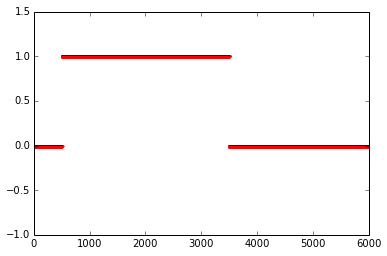

In [33]:
new_allsp=filtered_new1[:,:6000]
newtarget=np.zeros(6000)
newtarget[500:3500]=1
from sklearn import linear_model
clf = linear_model.LogisticRegression()
clf.fit (new_allsp.T,newtarget)
arr=np.abs(clf.coef_.argsort())[0,:]
print np.intersect1d(arr[-50:], neuronsWithInput).shape
plt.plot(clf.predict(new_allsp.T),"r.")
plt.plot(newtarget,"b,")
plt.ylim([-1,1.5])
plt.show()



[ 0.5007683   0.5655588   0.60618618  0.61260045  0.61711458  0.61720923
  0.61914175  0.62174155  0.62437861  0.64158059  0.64538957  0.65778915
  0.65940441  0.65999081  0.66395905  0.66554031  0.67089134  0.67136664
  0.67564688  0.67574467  0.67657444  0.6841759   0.68722633  0.68805772
  0.68948419  0.70862634  0.71137729  0.71431094  0.7248131   0.72538264
  0.72958634  0.73396551  0.73513242  0.73666792  0.7395514   0.73982016
  0.74175541  0.74958838  0.75092972  0.75548105  0.75632311  0.75713733
  0.76078199  0.76539756  0.76757767  0.76811059  0.77143277  0.78132869
  0.79450061  0.79457584  0.79468979  0.79568067  0.79726946  0.79982297
  0.80009962  0.80445812  0.80459344  0.80576404  0.80855551  0.81228064
  0.81340648  0.81370611  0.81506619  0.82259121  0.82339964  0.82398491
  0.82441743  0.82473309  0.83074731  0.83301474  0.83415143  0.83840012
  0.83892572  0.84017405  0.84106349  0.84193031  0.84963626  0.85237369
  0.85406484  0.86044389  0.86130964  0.86375712  0

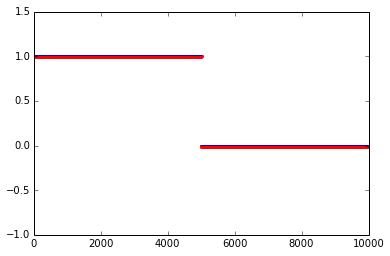

In [34]:
new_allsp=new_spiketrain
newtarget=np.zeros(new_spiketrain.shape[1])
newtarget[0:5000]=1
from sklearn import linear_model
clf = linear_model.LogisticRegression()
clf.fit (new_allsp.T,newtarget)
arr=np.abs(clf.coef_.argsort())[0,:]
print clf.coef_[0,arr[-100:]]
print labels[arr[-100:]]
plt.plot(clf.predict(new_allsp.T),"r.")
plt.plot(newtarget,"b,")
plt.ylim([-1,1.5])
plt.show()

(250, 2)
[202 216 238 104 157 160 223  24  56  61  42 113  71  63 147 141  74 205
  69 189 249 243   2  93 204  28  27  96  11 151 211 132 116  77 136  90
 117 152 186  94  83 246 183  46  32  12 129  13 201  76  20  97 231 221
 170  92 191 234 118  50 125 227 166 203 244 212  66 222 217  75  19 192
 171 214 130 229   9 163  29 233  31 123 134 188  58 155 218 106  48  43
  52 173  89 164 107 242 148  18 237 198]


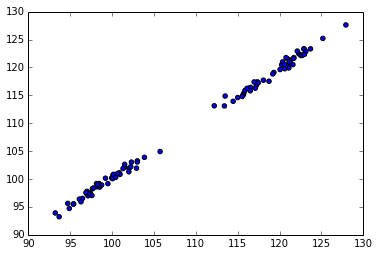

In [35]:
print X.shape
print arr[-100:]
plt.scatter(X[arr[-100:],0],X[arr[-100:],1])
plt.show()